In [19]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
def load_model(model_path, num_classes=2, device="cpu"):
    model = models.resnet50(weights=None) 
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

In [21]:
def predict_image(model, image_path, class_names, device="cpu"):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"[WARNING] Gagal baca gambar {image_path}: {e}")
        return None, None, None

    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)

    return class_names[pred.item()], probs[0][pred.item()].item(), pred.item()


In [22]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

In [23]:
def plot_classification_report(report_dict, class_names):
    metrics = ["precision", "recall", "f1-score"]
    for metric in metrics:
        values = [report_dict[label][metric] for label in class_names]
        plt.figure(figsize=(6, 4))
        sns.barplot(x=class_names, y=values)
        plt.ylim(0, 1)
        plt.title(f"{metric.capitalize()} per Class")
        plt.ylabel(metric.capitalize())
        plt.show()

In [24]:
def show_prediction(img_path, model, class_names, device, true_label=None):
    """Helper function buat nampilin image + prediksi"""
    pred, prob, _ = predict_image(model, img_path, class_names, device)
    if pred is None:
        return

    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis("off")
    title = f"Pred: {pred} ({prob:.2f})"
    if true_label:
        title += f"\nTrue: {true_label}"
    plt.title(title)
    plt.show()

Inference running on: cuda


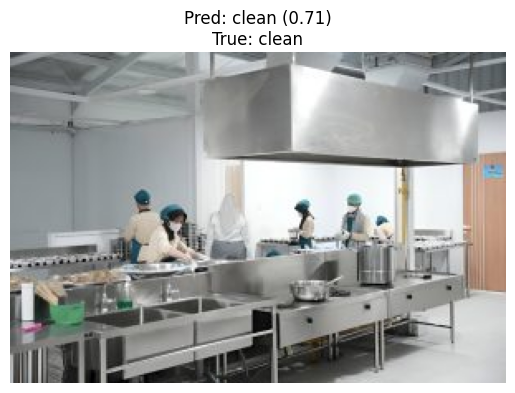


Showing samples from datasets...


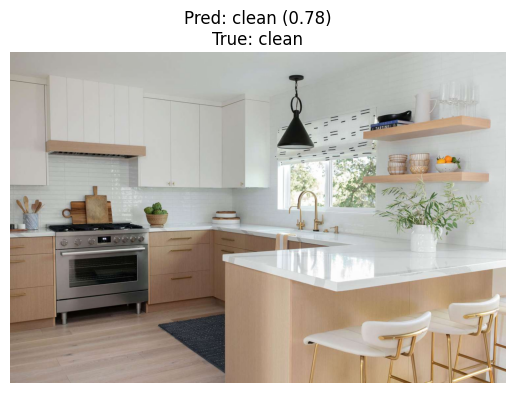

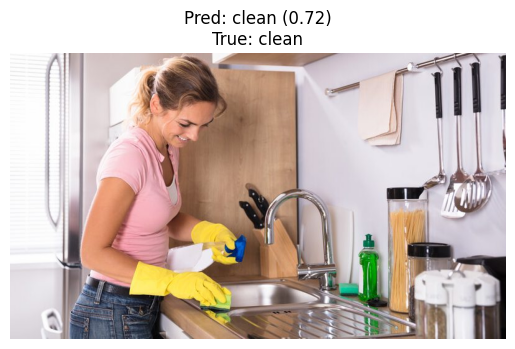

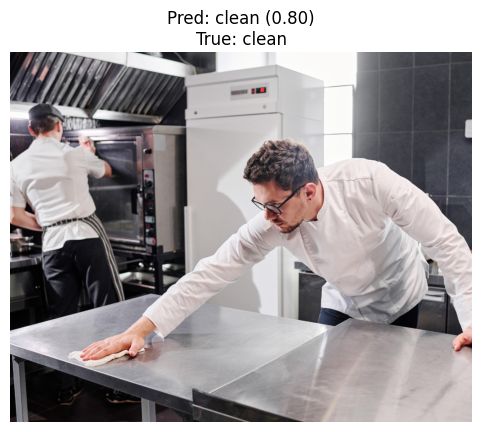

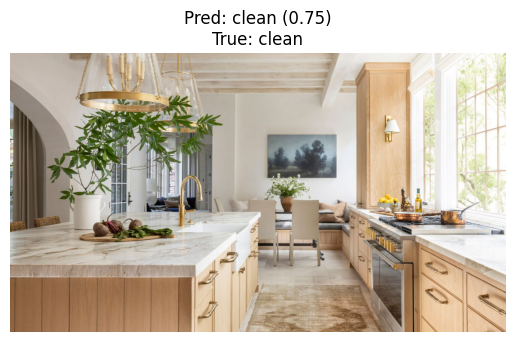

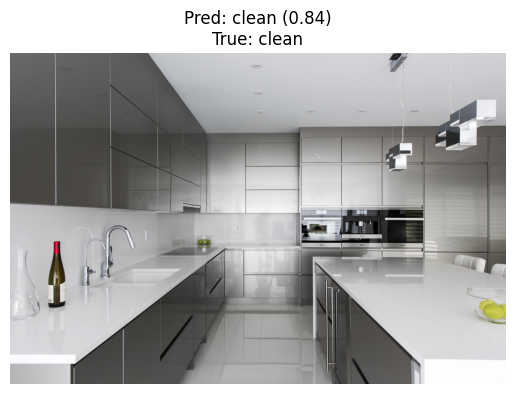


Evaluating from folder: ../dataset_dapur_split/val

Model Evaluation
Accuracy: 0.825

Classification Report:
               precision    recall  f1-score   support

       clean       0.75      1.00      0.86        21
       dirty       1.00      0.63      0.77        19

    accuracy                           0.82        40
   macro avg       0.88      0.82      0.82        40
weighted avg       0.87      0.82      0.82        40

Confusion Matrix:
 [[21  0]
 [ 7 12]]


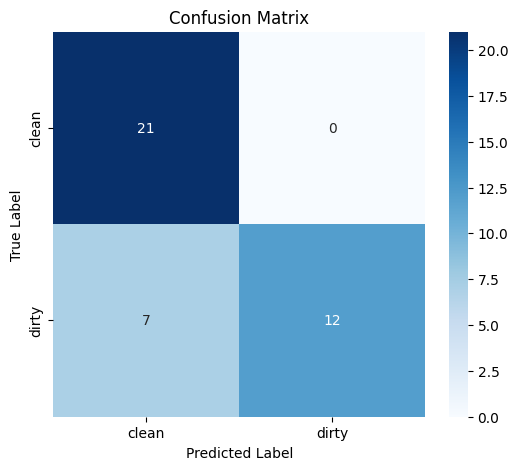

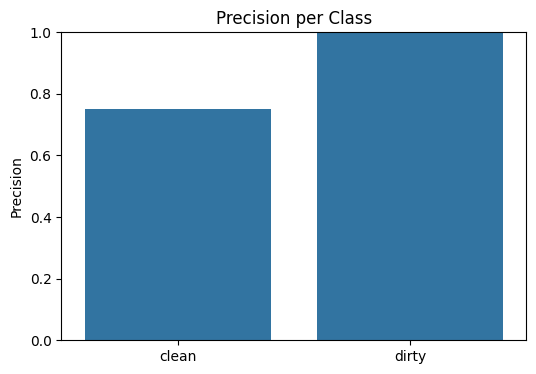

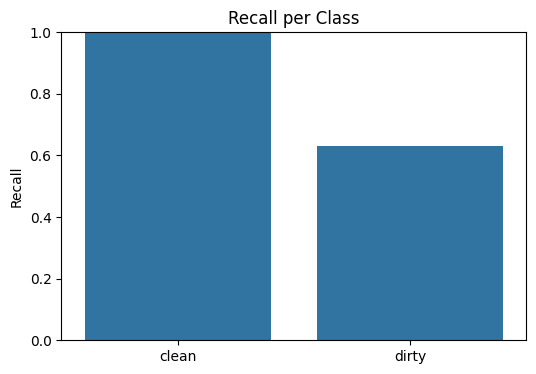

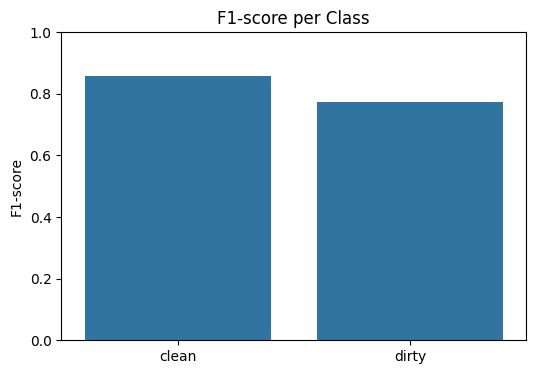

In [29]:
def main():
    # Config 
    model_path = "resnet50_kitchen.pth"
    class_names = ["clean", "dirty"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Inference running on: {device}")

    # Load model
    model = load_model(model_path, num_classes=len(class_names), device=device)

    test_image = "../dataset_dapur_split/val/test/dapur3.jpg"
    show_prediction(test_image, model, class_names, device, true_label="clean")

    sample_folder = "../dataset_dapur_split/val"
    print("\nShowing samples from datasets...")

    sample_images = []
    for root, _, files in os.walk(sample_folder):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                sample_images.append(os.path.join(root, f))
    sample_images = sample_images[:5]  # ambil 5 contoh pertama

    for img_path in sample_images:
        true_label = os.path.basename(os.path.dirname(img_path))
        show_prediction(img_path, model, class_names, device, true_label=true_label)

    # Evaluasi semua data di folder test
    print(f"\nEvaluating from folder: {sample_folder}")
    y_true, y_pred = [], []

    for root, _, files in os.walk(sample_folder):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(root, f)
                true_label = os.path.basename(root)
                if true_label not in class_names:
                    continue
                true_idx = class_names.index(true_label)

                pred_label, prob, pred_idx = predict_image(model, img_path, class_names, device)
                if pred_label is not None:
                    y_true.append(true_idx)
                    y_pred.append(pred_idx)

    # Hasil evaluasi
    print("\nModel Evaluation")
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc)

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Plot grafik 
    plot_confusion_matrix(cm, class_names)
    plot_classification_report(report, class_names)


if __name__ == "__main__":
    main()